In [2]:

#!pip install pygrib  # For PyGRIB

# url: https://cds.climate.copernicus.eu/api/v2
#key: {267762}:{48ec6a98-a4a4-44c7-b5ab-ef4a29808b72}
!pip install cdsapi
!pip install utils
!pip install pygrib  # For PyGRIB
!pip install cfgrib xarray netCDF4 
!pip install keras-tuner --upgrade

import cdsapi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import xarray as xr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

import keras_tuner

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-12-20 01:02:33.859864: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 01:02:33.900662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
api_key_content = """
url: https://cds.climate.copernicus.eu/api/v2
key: 267762:48ec6a98-a4a4-44c7-b5ab-ef4a29808b72
"""
with open('/home/jovyan/.cdsapirc', 'w') as file:
    file.write(api_key_content)

In [4]:


# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': [
#             '100m_u_component_of_wind', '100m_v_component_of_wind', 'sea_surface_temperature',
#             'surface_pressure', 
#         ],
#         'year': [
#             '2013', '2014', '2015'
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             42.25, -126, 32.5,
#             -114.2,
#         ],
#         'format': 'netcdf',
#     },
#     '2013-2015.netcdf')

In [5]:
# c_test = cdsapi.Client()

# c_test.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'variable': [
#             '100m_u_component_of_wind', '100m_v_component_of_wind', 'sea_surface_temperature',
#             'surface_pressure', 
#         ],
#         'year': [
#             '2019', '2020',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area': [
#             42.25, -126, 32.5,
#             -114.2,
#         ],
#         'format': 'netcdf',
#     },
#     'download2.netcdf')

In [6]:
# Open the GRIB file using xarray and cfgrib
ds1012 = xr.open_dataset('/home/jovyan/2010-2012.netcdf')
ds1315 = xr.open_dataset('/home/jovyan/2013-2015.netcdf')
ds_train = xr.concat([ds1012,ds1315], dim='time')

ds_test = xr.open_dataset('/home/jovyan/2022.netcdf')

ds_train['ws'] = (((ds_train["u100"])**2+(ds_train["v100"])**2)**0.5)
ds_test['ws'] = (((ds_test["u100"])**2+(ds_test["v100"])**2)**0.5)



In [7]:
#ds_test.to_netcdf('/home/jovyan/ds_test.nc')

In [8]:
sst_train = ds_train['sst'].mean(dim=['latitude', 'longitude'])
sst_test = ds_test['sst'].mean(dim=['latitude', 'longitude'])

# Flatten the 'sp' variable across latitude and longitude dimensions to get a time series
sp_train = ds_train['sp'].mean(dim=['latitude', 'longitude'])
sp_test = ds_test['sp'].mean(dim=['latitude', 'longitude'])

# Convert to pandas DataFrame
sst_train_df = sst_train.to_dataframe(name='sst')
sp_train_df = sp_train.to_dataframe(name='sp')
sst_test_df = sst_test.to_dataframe(name='sst')
sp_test_df = sp_test.to_dataframe(name='sp')

# Join the two dataframes on the time index
train_df = pd.concat([sst_train_df, sp_train_df], axis=1)
test_df = pd.concat([sst_test_df, sp_test_df], axis=1)

In [9]:
train_df

,sst,sp
time,,
2010-01-01 00:00:00,286.751740,93827.398438
2010-01-01 01:00:00,286.751648,93830.335938
2010-01-01 02:00:00,286.751495,93867.648438
2010-01-01 03:00:00,286.751373,93885.468750
2010-01-01 04:00:00,286.751221,93913.265625
...,...,...
2015-12-31 19:00:00,287.151398,93742.351562
2015-12-31 20:00:00,287.151642,93671.445312
2015-12-31 21:00:00,287.151947,93600.742188


In [10]:
X_train_df = train_df
X_test_df  = test_df

y_train = ds_train['ws'].data
y_test  = ds_test['ws'].data

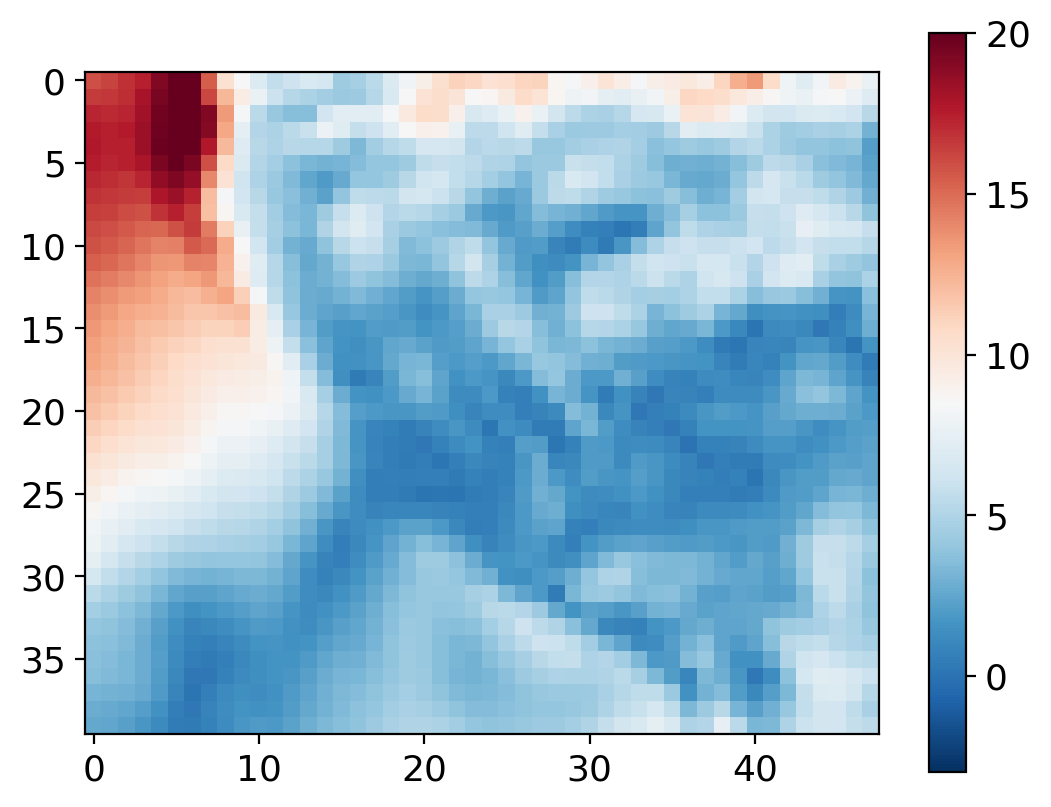

In [11]:
plt.imshow(y_train[0],cmap='RdBu_r',vmin=-3,vmax=20)
plt.colorbar()

In [12]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [13]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(52584, 2) (52584, 40, 48) (8760, 2) (8760, 40, 48)


In [14]:
(X_train.shape[1],)

(2,)

In [15]:
n_filters  = 32  # number of filters
activation     = 'relu' # activation function
kernel_size    = 2
learning_rate  = 0.001
minibatch_size = 128
num_epochs     = 100

In [16]:


### model using MSE as loss function
model_mse = Sequential()

model_mse.add(Dense(n_filters*5*6, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model_mse.add(Reshape((5,6,n_filters))) # shape: (12,18,32)

# Upsample to 10x12
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 20x24
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 40x48
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model_mse.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

###-------------------------------------------------------------------------------------------
### model using MAE as loss function
model_mae = Sequential()

model_mae.add(Dense(n_filters*5*6, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model_mae.add(Reshape((5,6,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model_mae.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model_mae.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model_mae.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model_mae.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model_mae.summary()
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 960)               2880      
                                                                 
 reshape (Reshape)           (None, 5, 6, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 12, 32)       4128      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 20, 24, 32)       4128      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 40, 48, 32)       4128      
 ranspose)                                                       
                                                        

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

###------------mse------------
history_mse = model_mse.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

###------------mae------------
history_mae = model_mae.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])


Epoch 1/100
329/329 [==============================] - 16s 45ms/step - loss: 13.8985 - val_loss: 8.1731
Epoch 2/100
329/329 [==============================] - 15s 45ms/step - loss: 8.4445 - val_loss: 7.9296
Epoch 3/100
329/329 [==============================] - 15s 45ms/step - loss: 8.2867 - val_loss: 7.8406
Epoch 4/100
329/329 [==============================] - 15s 45ms/step - loss: 8.2209 - val_loss: 7.7965
Epoch 5/100
329/329 [==============================] - 15s 45ms/step - loss: 8.1642 - val_loss: 7.8129
Epoch 6/100
329/329 [==============================] - 15s 45ms/step - loss: 8.1357 - val_loss: 7.7903
Epoch 7/100
329/329 [==============================] - 15s 44ms/step - loss: 8.1138 - val_loss: 7.7651
Epoch 8/100
329/329 [==============================] - 15s 45ms/step - loss: 8.1220 - val_loss: 7.7555
Epoch 9/100
329/329 [==============================] - 15s 45ms/step - loss: 8.1046 - val_loss: 7.8145
Epoch 10/100
329/329 [==============================] - 15s 45ms/step - 

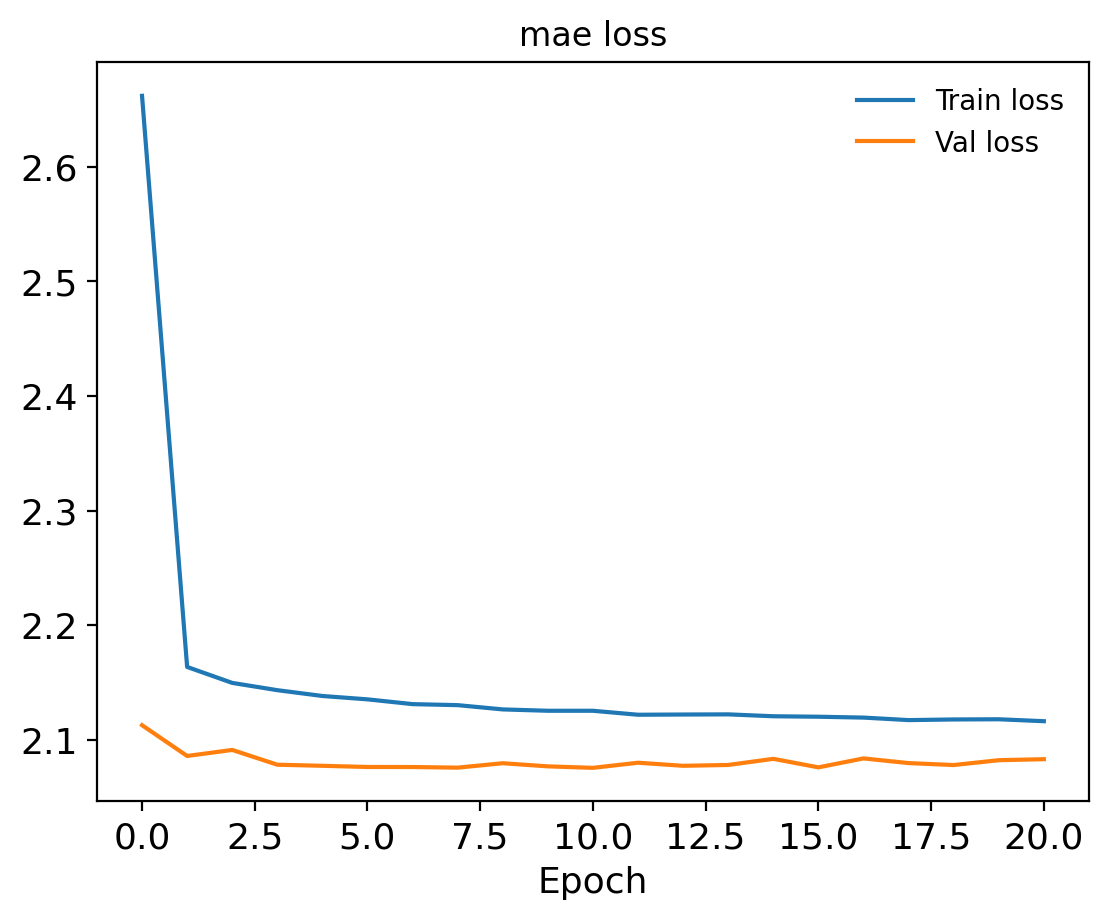

In [18]:
# plt.subplot(1, 2, 1)
# plt.plot(history_mse.history['loss'])
# plt.plot(history_mse.history['val_loss'])
# plt.title('mse loss', fontsize=12)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# plt.subplot(1, 2, 2)
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title('mae loss', fontsize=12)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

plt.savefig('losses.png', format='png')

In [19]:
cwd = os.getcwd()
model_path = os.path.join(cwd,'saved_model')
model_mse.save(os.path.join(model_path,'CNN_ws_mse.h5'))
model_mae.save(os.path.join(model_path,'CNN_ws_mae.h5'))

In [20]:
###------------mse------------
y_test_mse_pre = model_mse.predict(X_test)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 40, 48)
y_test_mse_pre = xr.Dataset(coords={'time': ds_test.time.values, 
                               'latitude': ds_test.latitude.values, 
                               'longitude': ds_test.longitude.values},
                       data_vars=dict(ws=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

###------------mae------------
y_test_mae_pre = model_mae.predict(X_test)
y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 40, 48)
y_test_mae_pre = xr.Dataset(coords={'time': ds_test.time.values, 
                               'latitude': ds_test.latitude.values, 
                               'longitude': ds_test.longitude.values},
                       data_vars=dict(ws=(['time', 'latitude', 'longitude'], y_test_mae_pre)))



274/274 [==============================] - 1s 5ms/step


In [21]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 40, longitude: 48)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float32 42.25 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -114.8 -114.5 -114.2
Data variables:
    ws         (time, latitude, longitude) float32 9.386 10.1 ... 5.232 5.411

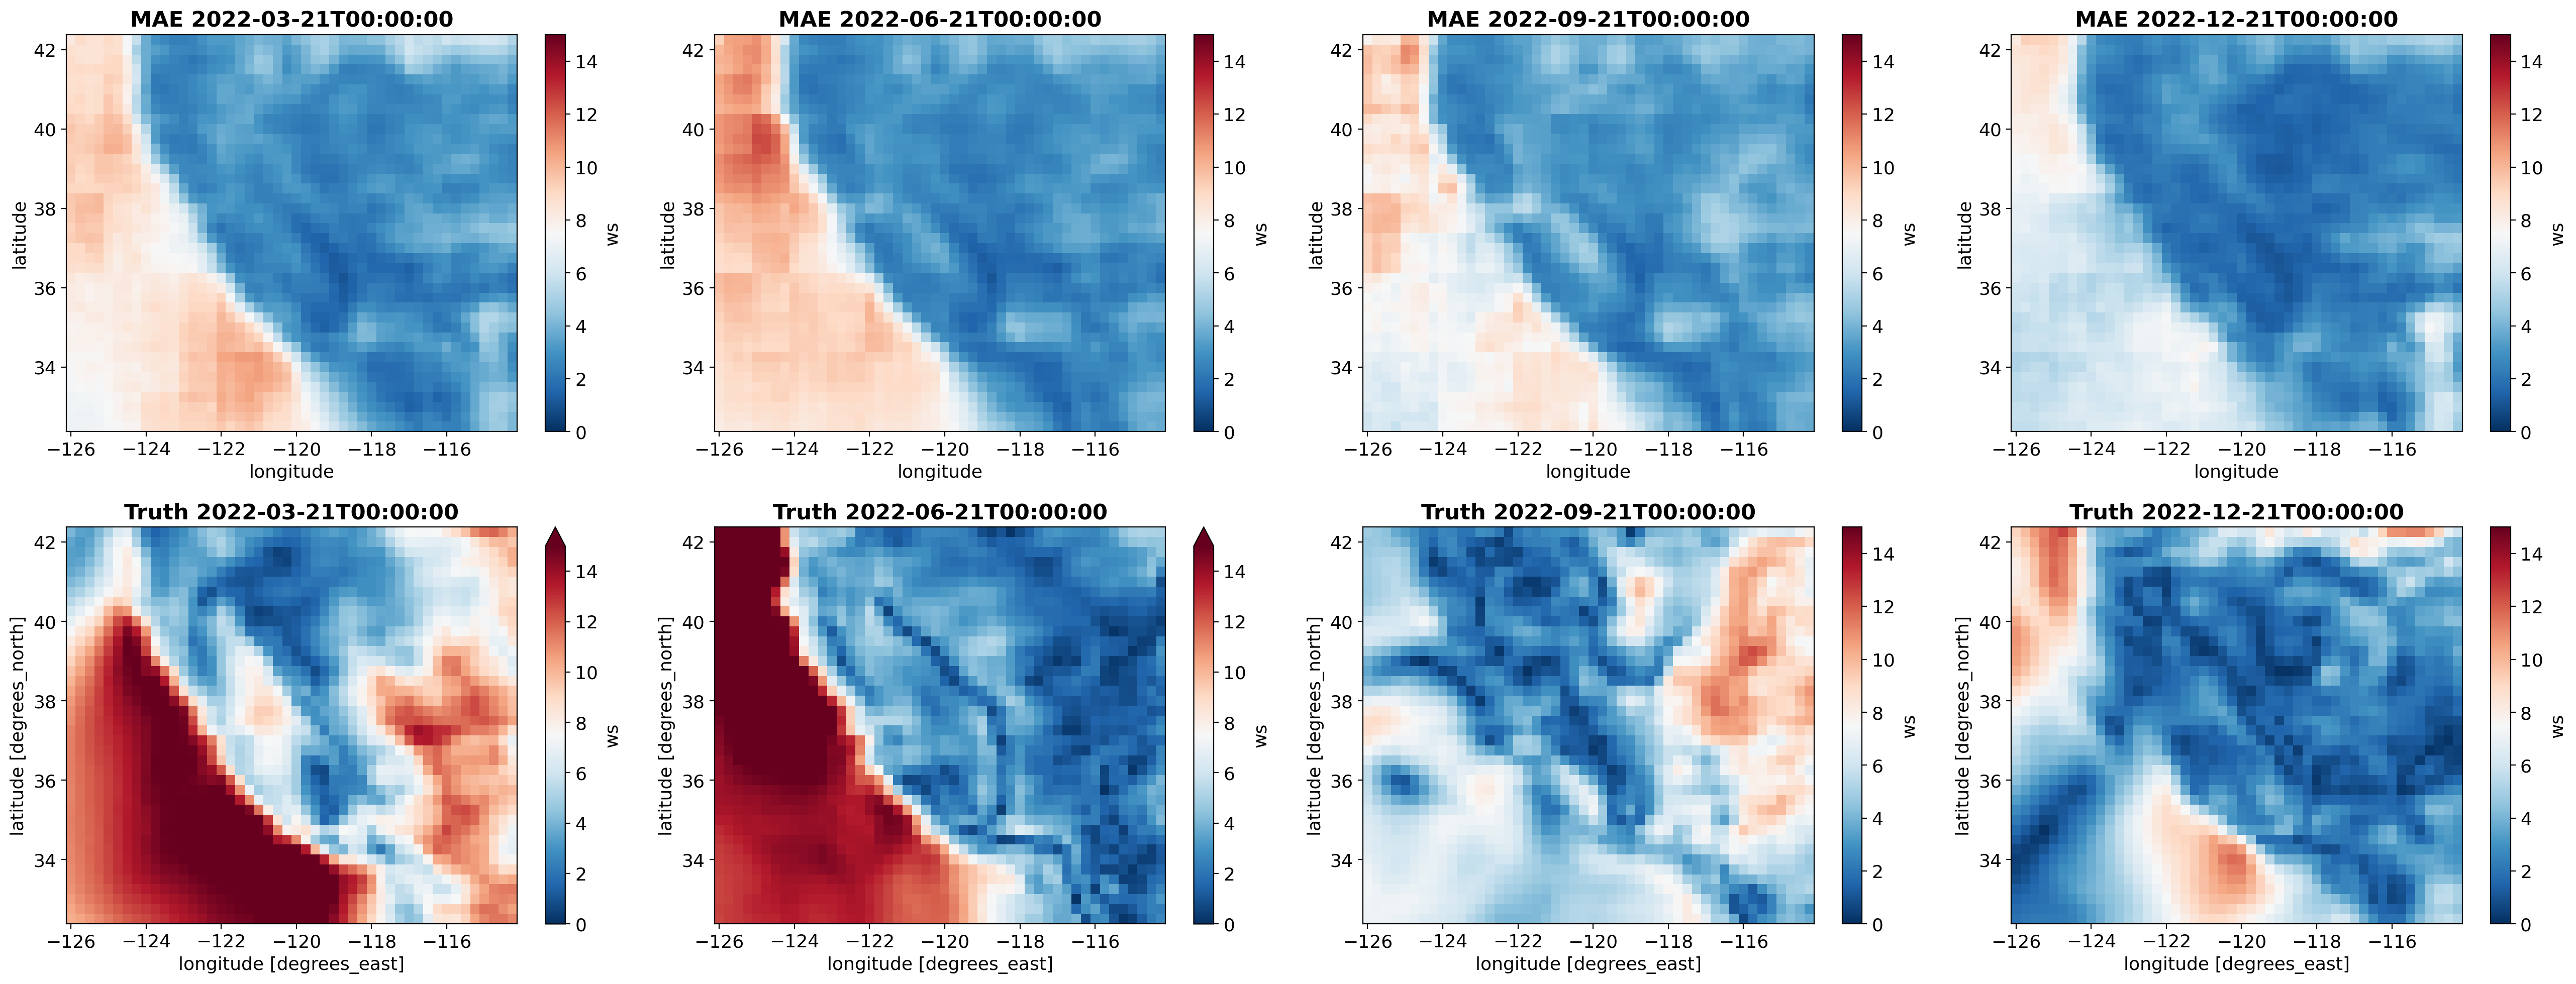

In [33]:


#-------------------------------------------------
yrs = ['2022-03-21T00:00:00', '2022-06-21T00:00:00', '2022-09-21T00:00:00', '2022-12-21T00:00:00']
vmin, vmax = 0, 15
cmap = 'RdBu_r'

fig, axes = plt.subplots(figsize=(26, 10), ncols=4, nrows=2)

for i, ax in enumerate(axes.flat):
    if i < 4:
        # First row with "mae" titles
        y_test_mae_pre.ws.sel(time=yrs[i]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(f'MAE {yrs[i]}', fontweight='bold')
    else:
        # Second row with "truth" titles
        ds_test.ws.sel(time=yrs[i - 4]).plot(ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(f'Truth {yrs[i - 4]}', fontweight='bold')

plt.tight_layout()
plt.savefig('my_plot.png', format='png')

In [23]:
axes

array([[<Axes: title={'center': 'MAE 2022-03-21T00:00:00'}, xlabel='longitude', ylabel='latitude'>,
        <Axes: title={'center': 'MAE 2022-06-21T00:00:00'}, xlabel='longitude', ylabel='latitude'>,
        <Axes: title={'center': 'MAE 2022-09-21T00:00:00'}, xlabel='longitude', ylabel='latitude'>,
        <Axes: title={'center': 'MAE 2022-12-21T00:00:00'}, xlabel='longitude', ylabel='latitude'>],
       [<Axes: title={'center': 'Truth 2022-03-21T00:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
        <Axes: title={'center': 'Truth 2022-06-21T00:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
        <Axes: title={'center': 'Truth 2022-09-21T00:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
        <Axes: title={'center': 'Truth 2022-12-21T00:00:00'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>]],
      dtype=object)

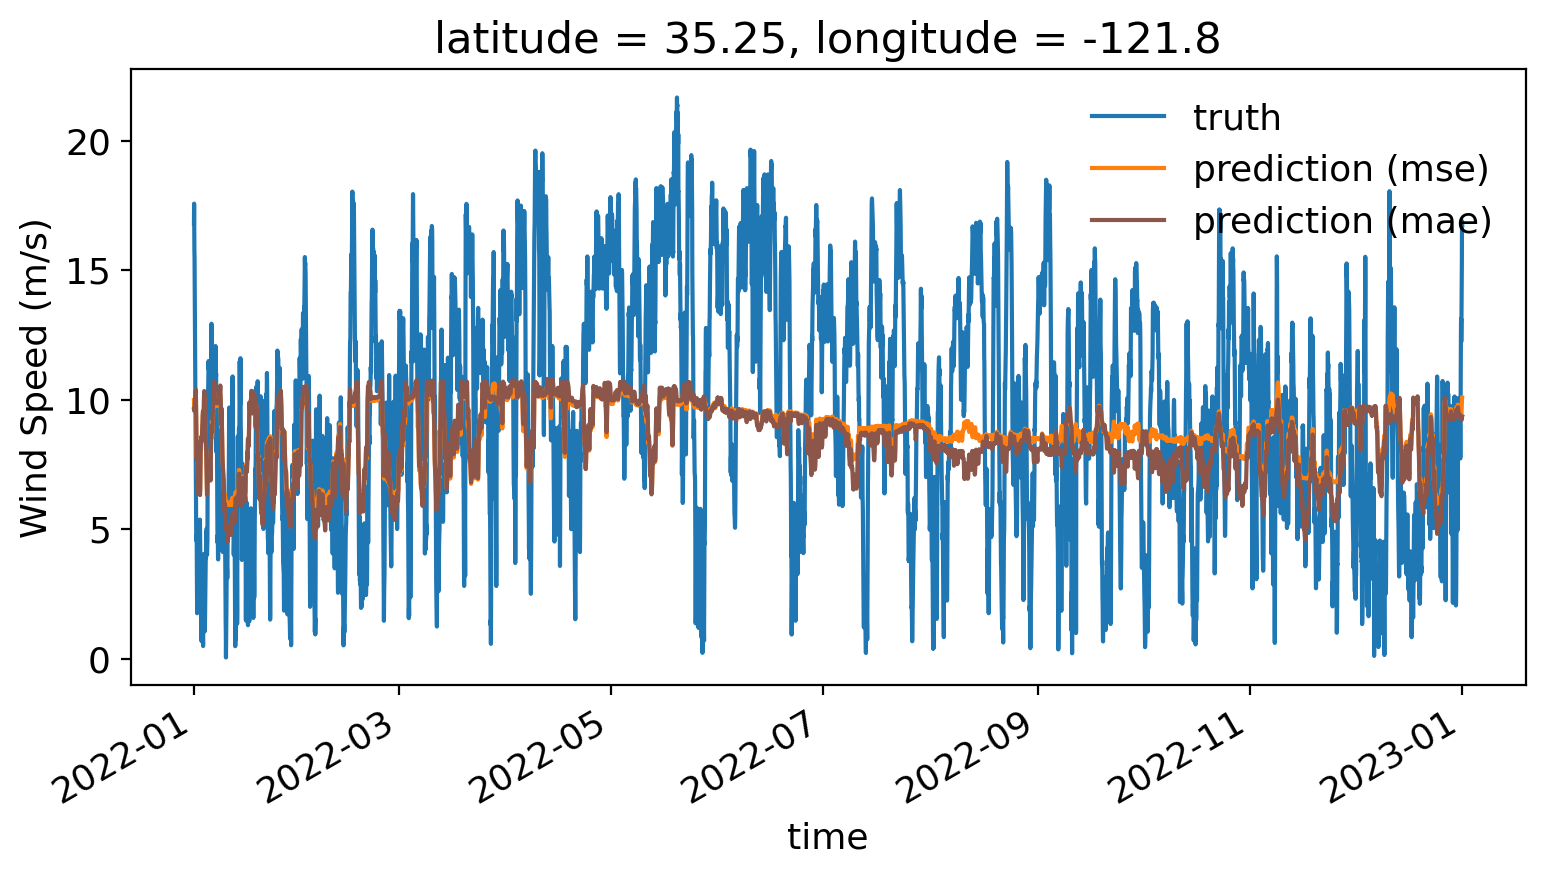

In [24]:
lat = 35.35
lon = -121.75  #%360

fig,ax = plt.subplots(figsize=(9,4))
ws_test = ds_test.ws.sel(time=slice("2022-01-01T00:00:00.000000000","2022-12-31T23:00:00.000000000"))
ws_test.sel(latitude=lat,longitude=lon,method='nearest').plot(ax=ax,label='truth')

y_test_mse_pre = y_test_mse_pre.sel(time=slice("2022-01-01T00:00:00","2022-12-31T23:00:00"))
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').ws.plot(ax=ax,label='prediction (mse)')

y_test_mae_pre = y_test_mae_pre.sel(time=slice("2022-01-01T00:00:00","2022-12-31T23:00:00"))
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').ws.plot(ax=ax,color='tab:brown',label='prediction (mae)')
ax.legend()
ax.set_ylabel('Wind Speed (m/s)')

plt.savefig('certain coord.png', format='png')

In [25]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 40, longitude: 48)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float32 42.25 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -114.8 -114.5 -114.2
Data variables:
    ws         (time, latitude, longitude) float32 9.386 10.1 ... 5.232 5.411

In [26]:
def global_mean_std_plot(X,label,color,ax,var='ws'):
    weights  = np.cos(np.deg2rad(X.latitude))
    ws_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    ws_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, ws_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,ws_mean+ws_std,ws_mean-ws_std,facecolor=color,alpha=0.2)

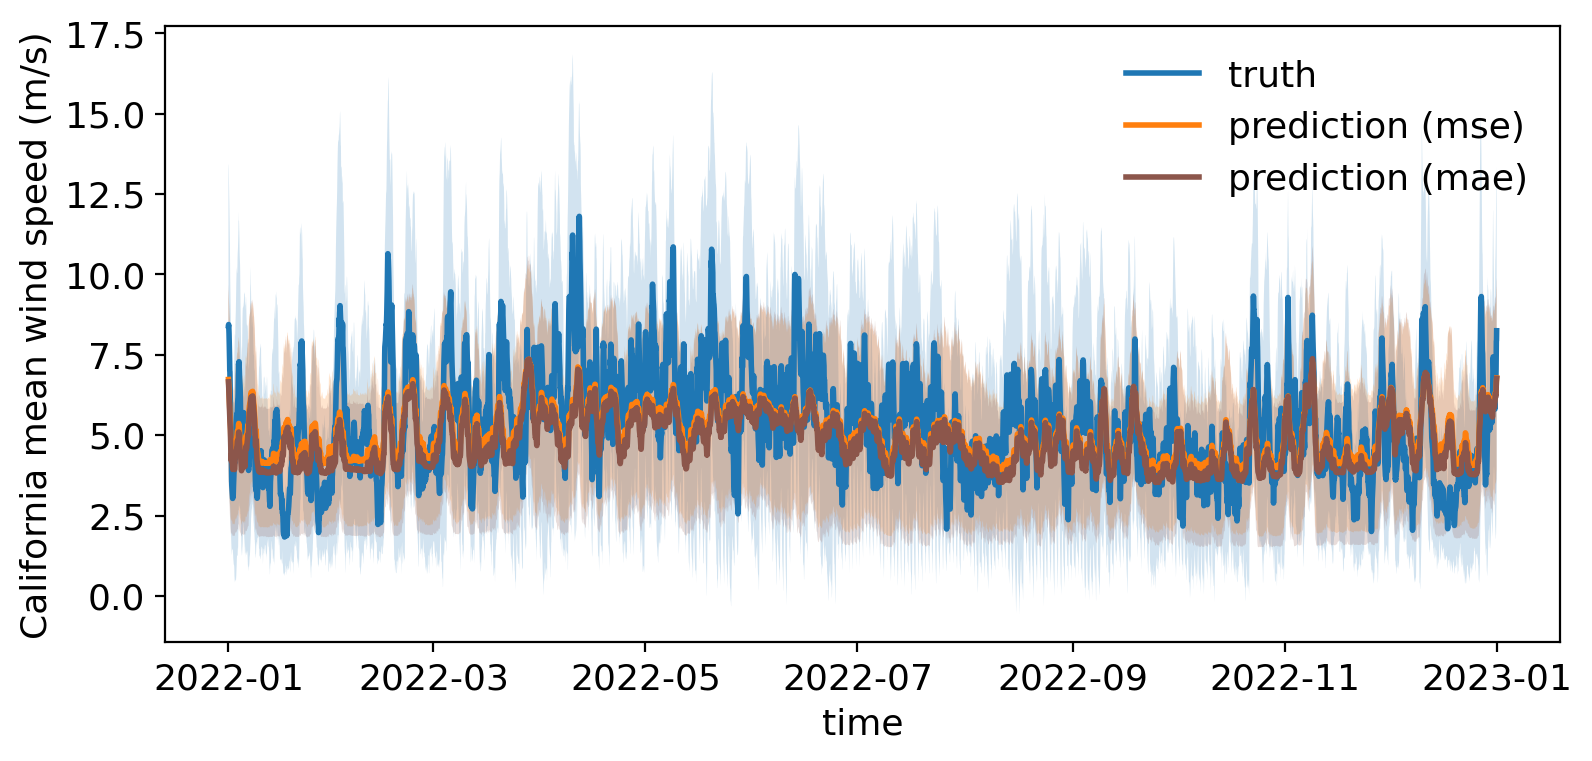

In [27]:
fig,ax = plt.subplots(figsize=(9,4))

weights  = np.cos(np.deg2rad(ws_test.latitude))
ws_mean = ds_test['ws'].weighted(weights).mean(['latitude', 'longitude'])
ws_std  = ds_test['ws'].weighted(weights).std(['latitude', 'longitude'])

x = ds_test.time.data

ax.plot(x, ws_mean, label='truth',color='tab:blue',linewidth=2)
ax.fill_between(x,ws_mean+ws_std,ws_mean-ws_std,facecolor='tab:blue',alpha=0.2)

global_mean_std_plot(y_test_mse_pre,label='prediction (mse)',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_mae_pre,label='prediction (mae)',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('California mean wind speed (m/s)')
ax.legend()

plt.savefig('mean speed.png', format='png')

In [28]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:    (time: 8760, latitude: 40, longitude: 48)
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float32 42.25 42.0 41.75 41.5 ... 33.0 32.75 32.5
  * longitude  (longitude) float32 -126.0 -125.8 -125.5 ... -114.8 -114.5 -114.2
Data variables:
    ws         (time, latitude, longitude) float32 9.386 10.1 ... 5.232 5.411

In [35]:
# get global mean temperature
def global_mean(X,var='ws'):
    weights  = np.cos(np.deg2rad(X.latitude))
    ws_mean = X['ws'].weighted(weights).mean(['latitude', 'longitude']).data
    return ws_mean

ws_mean_xr = global_mean(ds_test)
ws_mean_mse_pre = global_mean(y_test_mse_pre)
ws_mean_mae_pre = global_mean(y_test_mae_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = ds_test.sel(latitude=lat,longitude=lon,method='nearest').ws.to_dataframe().index
df_globalmean_test["truth"] = ws_mean_xr
df_globalmean_test["prediction_mse"] = ws_mean_mse_pre
df_globalmean_test["prediction_mae"] = ws_mean_mae_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

                 time     truth  prediction_mse  prediction_mae
0 2022-01-01 00:00:00  8.404290        6.731121        6.657520
1 2022-01-01 01:00:00  8.440994        6.656726        6.568541
2 2022-01-01 02:00:00  8.411901        6.558894        6.454955
3 2022-01-01 03:00:00  8.299248        6.435846        6.317008
4 2022-01-01 04:00:00  8.161176        6.316838        6.183607
5 2022-01-01 05:00:00  7.965810        6.218785        6.077648
6 2022-01-01 06:00:00  7.807757        6.065633        5.908446
7 2022-01-01 07:00:00  7.556662        5.952015        5.772855
8 2022-01-01 08:00:00  7.301312        5.884474        5.690908
9 2022-01-01 09:00:00  7.004755        5.783365        5.571998


,time,truth,prediction_mse,prediction_mae
count,8760,8760.000000,8760.000000,8760.000000
mean,2022-07-02 11:30:00,5.332764,5.022228,4.785700
min,2022-01-01 00:00:00,1.833208,3.910815,3.529425
25%,2022-04-02 05:45:00,4.123814,4.364911,4.061265
50%,2022-07-02 11:30:00,5.165375,4.891240,4.643872
75%,2022-10-01 17:15:00,6.339730,5.599028,5.420596
max,2022-12-31 23:00:00,11.805041,7.361757,7.380999
std,NaN,1.602602,0.740180,0.810985
